#Importing the Necessary Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.filters import threshold_local
from PIL import Image

#Loading the Image

In [ ]:
image_path = '/content/20201005_215920.jpg'
img = Image.open(image_path)
original = img.copy()

#Resizing and Displaying the Image

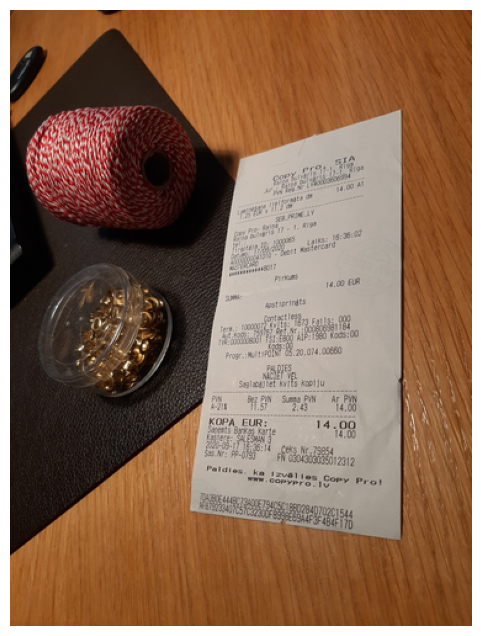

In [ ]:
def pillow_resize(image, ratio):
    width = int(image.width * ratio)
    height = int(image.height * ratio)
    return image.resize((width, height), Image.LANCZOS)


resize_ratio = 500 / img.height
image  = pillow_resize(img, resize_ratio)
image = np.array(image)

plt.figure(figsize=(6,8))
plt.imshow(image)
plt.axis('off')
plt.show()

#Converting Image to Grayscale

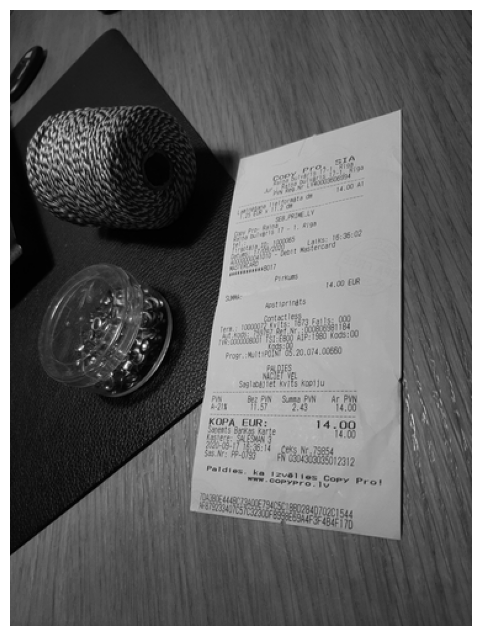

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,8))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

#Applying Gaussian Blur to Grayscale Image

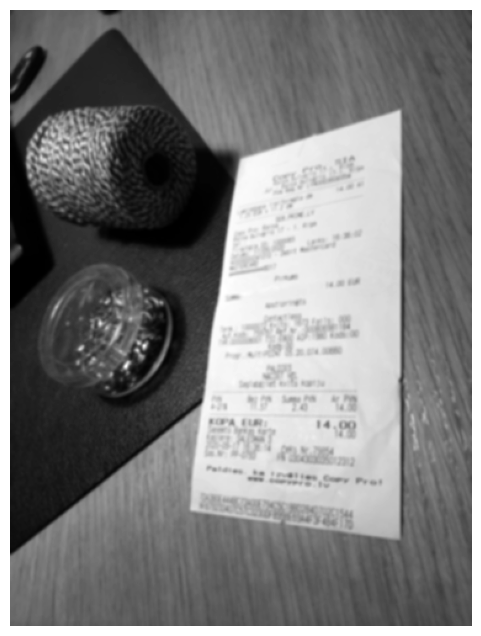

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(6,8))
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.show()

#Dilating the Image with a Rectangular Kernel

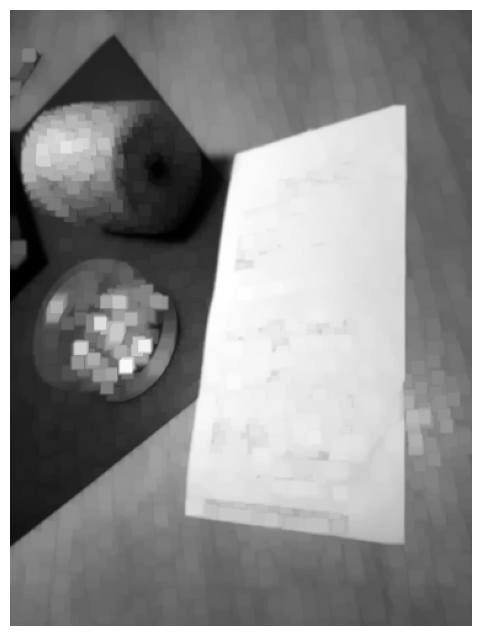

In [ ]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)

plt.figure(figsize=(6,8))
plt.imshow(dilated, cmap='gray')
plt.axis('off')
plt.show()

#Detecting Edges

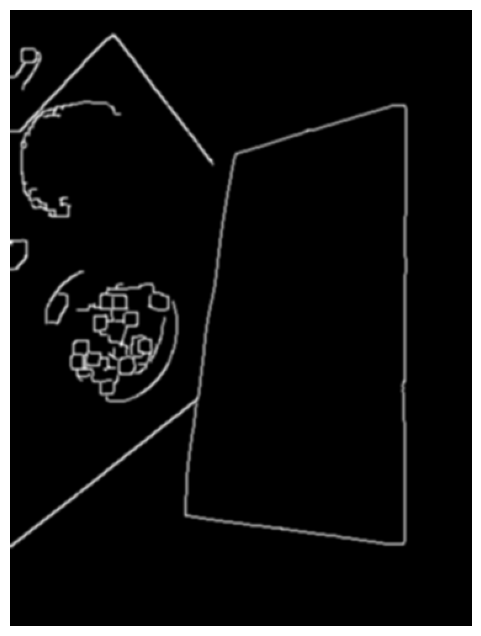

In [ ]:
edges = cv2.Canny(dilated, 40, 200, apertureSize=3)
blurred_edges = cv2.GaussianBlur(edges, (5, 5), 0)

plt.figure(figsize=(6,8))
plt.imshow(blurred_edges, cmap='gray')
plt.axis('off')
plt.show()

#Detecting and Overlaying Contours

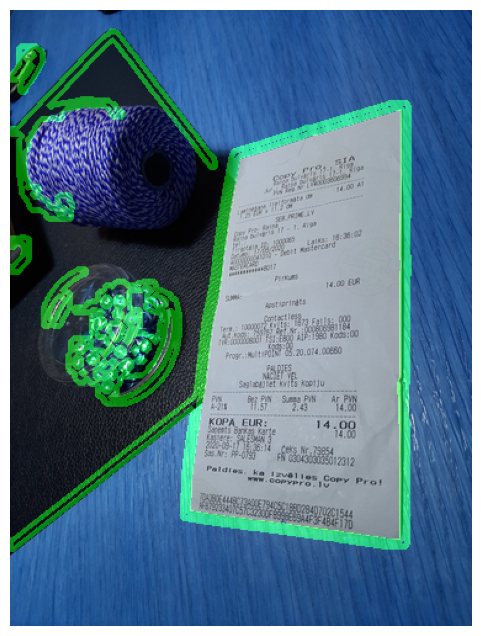

In [ ]:
contours, hierarchy = cv2.findContours(blurred_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(image)
cv2.drawContours(mask, contours, -1, (0, 255, 0), 3)
image_with_contours = cv2.addWeighted(image, 1.0, mask, 0.5, 0)

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#Highlighting Largest Contours

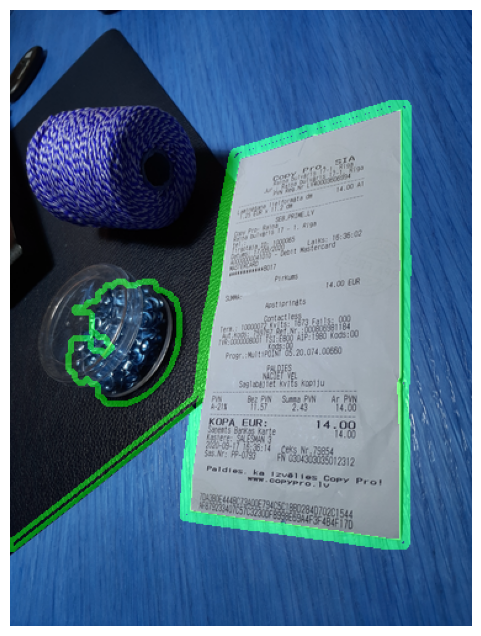

In [ ]:
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

mask = np.zeros_like(image)
cv2.drawContours(mask, largest_contours, -1, (0, 255, 0), thickness=3)
image_with_largest_contours = cv2.addWeighted(image, 1.0, mask, 0.5, 0)

plt.figure(figsize=(6, 8))
plt.imshow(cv2.cvtColor(image_with_largest_contours, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#Identifying and Highlighting Receipt Contour

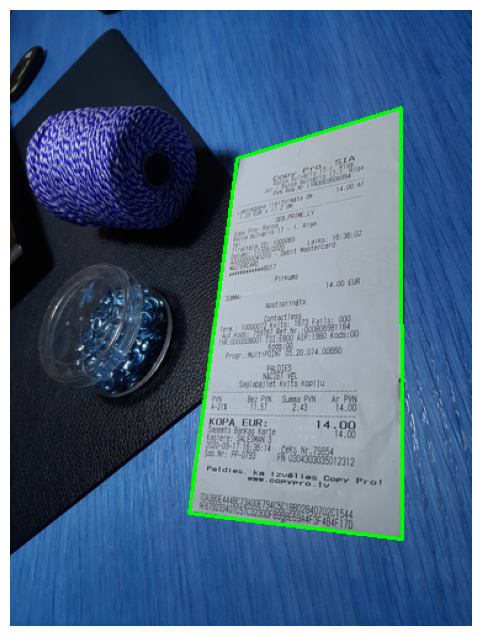

In [ ]:
def get_receipt_contour(contours):
    def polygon_approximation_of_contour(contour):
        peri = cv2.arcLength(contour, True)
        return cv2.approxPolyDP(contour, 0.032 * peri, True)

    for c in contours:
        approx = polygon_approximation_of_contour(c)
        if len(approx) == 4:
            return approx

receipt_contour= get_receipt_contour(largest_contours)


image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(image_with_receipt_contour, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#Converting Contour to Rectangle for Receipt Perspective Correction

In [ ]:
def contour_to_rectangle(contour):
    pts = contour.reshape(4, 2)

    min_sum_idx = np.argmin(pts.sum(axis=1))
    max_sum_idx = np.argmax(pts.sum(axis=1))

    min_diff_idx = np.argmin(np.diff(pts, axis=1))
    max_diff_idx = np.argmax(np.diff(pts, axis=1))

    rect = np.zeros((4, 2), dtype="float32")
    rect[0] = pts[min_sum_idx]
    rect[1] = pts[min_diff_idx]
    rect[2] = pts[max_sum_idx]
    rect[3] = pts[max_diff_idx]

    return rect / resize_ratio

#Perspective Transformation for Receipt Scanning and Correction

In [ ]:
def perspective_transform(image, rect):
    width = 800
    height = 1600

    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    transformed_image = cv2.warpPerspective(image, M, (width, height))

    return transformed_image

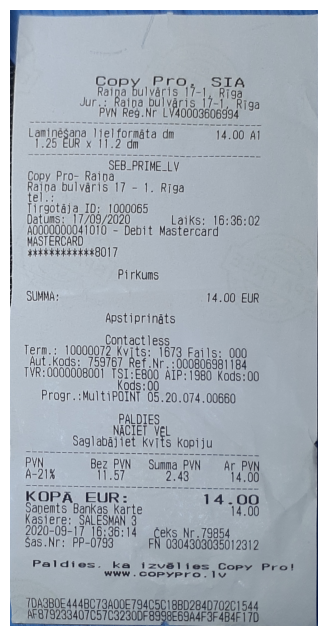

In [ ]:
scanned = perspective_transform(np.array(original.copy()), contour_to_rectangle(receipt_contour))
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(scanned, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#Applying Thresholding for Receipt Text Extraction and Enhancement

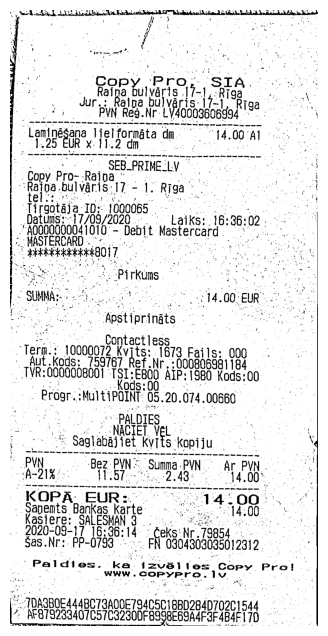

In [ ]:
gray = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
T = threshold_local(gray, 21, offset=5, method="gaussian")
final_result = (gray > T).astype("uint8") * 255

plt.figure(figsize=(6,8))
plt.imshow(final_result, cmap='gray')
plt.axis('off')
plt.show()

#Saving Processed Receipt

In [ ]:
output = Image.fromarray(final_result)
output.save('Receipt.png')